# Deep Kernel Learning

In [1]:
%%capture
%pip install git+https://github.com/lightning-uq-box/lightning-uq-box.git

## Theoretic Foundation

## Recap of Gaussian Processes (GPs):

The goal of previously introduced methods was to find a distribution over the weights of a parameterized function i.e. a neural network. In contrast, the basic idea of a Gaussian Process (GP) is to instead consider a distribution over possible functions, that fit the data in some way. Formally,

*"A Gaussian process is a collection of random variables, any finite number of which have a joint Gaussian distribution."* [Seeger, 2004](https://www.worldscientific.com/doi/abs/10.1142/S0129065704001899)

Precisely, a GP can be described by a possibly infinite amount of function values
$$
    f(x) \sim \mathcal{GP}(m(x),k_{\gamma}(x)),
$$

such that any finite collection of function values $f$ has a joint Gaussian
distribution,

$$
 f = f(X) = [f(x_1),\dots,f(x_K)]^{\top} \sim \mathcal{N}(m_X,\mathcal{K}_{X,X}),
$$

with a mean vector, $(m_X)i = m(x_i)$, and covariance matrix, $(\mathcal{K}_{X,X})_{ij} = k_{\gamma}(x_i,x_j)$,
stemming from the mean function $m$ and covariance kernel of the GP, $k_{\gamma}$, that is parametrized by $\gamma$. A commonly used covariance function is the squared exponential, also referred to as Radial Basis Function (RBF) kernel, exponentiated quadratic or Gaussian kernel:

$$
    k_{\gamma}(x,x') = \text{cov}(f(x),f(x')) = \eta^2\exp{\left(-\frac{1}{2l^2}|x-x'|^2\right)}.
$$

Where $\gamma =( \eta^2, l)$ and $\eta^2$ can be set to $1$ or tuned as a hyperparameter. By default the lengthscale $l=1$ but can also be optimized over. Now the GP, $f (x) \sim GP(m(x), k(x, x'))$, as a distribution over functions can be used to solve a regression problem. Following [Seeger, 2004](https://www.worldscientific.com/doi/abs/10.1142/S0129065704001899), consider the simple special case where the observations are noise free and you have training data $\mathcal{D}_{\mathrm{train}} = \{(x_i, y_i)\}_{i=1}^{K}$ with $X=(x_i)_{i=1}^K$ and $Y=(y_i)_{i=1}^K$. The joint prior distribution of the training outputs, $Y$, and the test outputs $f_*=f_*(X_*)= (f(x_k))_{k=1}^m$ where $X_* = (x_k)_{k=1}^m$ are the test points, according to the prior is

$$
p(Y,f_*) = \mathcal{N}\bigg(0, \Bigg[ 
\begin{array}{rr}
\mathcal{K}_{X,X} & \mathcal{K}_{X,X_*} \\
\mathcal{K}_{X_*,X} & \mathcal{K}_{X_*,X_*} \\\
\end{array} \Bigg] \bigg).
$$

Here the mean function is assumed to be $m_X = 0$ and $\mathcal{K}_{X,X_*}$ denotes the $K \times m$ matrix of the covariances evaluated at all pairs of training and test points, and similarly for the other entries $\mathcal{K}_{X,X}$, $\mathcal{K}_{X_*,X_*}$ and $\mathcal{K}_{X_*,X}$. To make predictions based on the knowledge of the training points, conditioning on the prior observations is used and yields,
$$
  p(f_*|X_*, X, Y) = \mathcal{N}(\mathcal{K}_{X_*,X}\mathcal{K}_{X,X}^{-1}Y, \mathcal{K}_{X_*,X_*}-\mathcal{K}_{X_*,X_*}\mathcal{K}_{X,X}^{-1}\mathcal{K}_{X,X_*})\\
  = \mathcal{N}(m(X,X_*,Y), \tilde{\mathcal{K}}_{X,X_*}).
$$

Now to generate function values on test points, one uses samples from the posterior distribution $f_*(X_*) \sim \mathcal{N}(m(X,X_*,Y), \tilde{K}(X, X_*))$.  To illustrate how we can obtain these samples from the posterior distribution, consider a Gaussian with arbitrary mean $m$ and covariance $K$, i.e. $f_* \sim \mathcal{N}(m,K)$. For this one can use a scalar Gaussian generator, which is available in many packages:
- Compute the Cholesky decomposition of $K=LL^T$, where $L$ is a lower triangular matrix. This works because $K$ is symmetric by definition.
- Then, draw multiple $u \sim \mathcal{N}(0, I)$.
- Now, compute the samples with $f_* = m + Lu$. This has the desired mean, $m$ and covariance $L\mathbb{E}(uu^T)L^T = LL^T = K$.

The above can be extended to incorporate noisy measurements $y \rightarrow y + e$, see [Seeger, 2004](https://www.worldscientific.com/doi/abs/10.1142/S0129065704001899), or noise on the inputs as in [Johnson, 2019](https://ieeexplore.ieee.org/abstract/document/8746634). Both of these extensions require tuning of further hyperparameters, yet beneficially allow to incorporate a prediction of aleatoric uncertainty in a GP.

For example, assume additive Gaussian noise on the distribution of the function values,

$$
  p(y(x)|f(x)) =  \mathcal{N}(y(x); f(x),\sigma^2).
$$

Then the predictive distribution of the GP evaluated at the
$K_*$ test points, $X_*$, is given by

$$
 p(f_*|X_*,X,Y,\gamma,\sigma^2) = \mathcal{N}(\mathbb{E}[f_*],\text{cov}(f_*)),
$$

$$
 \mathbb{E}[f_*] = m_{X_*}  + \mathcal{K}_{X_*,X}[\mathcal{K}_{X,X}+\sigma^2 I]^{-1}Y
$$

$$
 \text{cov}(f_*) = \mathcal{K}_{X_*,X_*} - \mathcal{K}_{X_*,X}[\mathcal{K}_{X,X}+\sigma^2 I]^{-1}\mathcal{K}_{X,X_*}.
$$

Here $m_{X_*}$ is the $K_* \times 1$ mean vector, which is assumed to be zero in the previous case.

In both cases, with and without additive noise on the function values, the GP is trained by learning interpretable kernel hyperparameters. The log marginal likelihood of the targets $y$ - the probability of the data conditioned only on kernel hyperparameters $\gamma$ - provides a principled probabilistic framework for kernel learning:
$$
 \log p(y | \gamma, X) \propto -\left(y^{\top}(\mathcal{K}_{\gamma}+\sigma^2 I)^{-1}y + \log|\mathcal{K}_{\gamma} + \sigma^2 I|\right),
$$
where $\mathcal{K}_{\gamma}$ is used for $\mathcal{K}_{X,X}$ given $\gamma$. Kernel learning can be achieved by optimizing the above with respect to $\gamma$.

The computational bottleneck for inference is solving the linear system
$(\mathcal{K}_{X,X}+\sigma^2 I)^{-1}y$, and for kernel learning it is computing
the log determinant $\log|\mathcal{K}_{X,X}+ \sigma^2 I|$ in the marginal likelihood.
The standard approach is to compute the Cholesky decomposition of the
$K \times K$ matrix $\mathcal{K}_{X,X}$, which
requires $\mathcal{O}(K^3)$ operations and $\mathcal{O}(K^2)$ storage.
After inference is complete, the predictive mean costs $\mathcal{O}(K)$,
and the predictive variance costs $\mathcal{O}(K^2)$, per test point
$x_*$.

## Deep Kernel Learning (DKL)


 Conceptually DKL consists of a NN architecture that extracts a feature representation of the input $x$ and fits an approximate GP on top of these features to produce a probabilistic output [Wilson, 2016](http://proceedings.mlr.press/v51/wilson16.pdf). DKL combines GPs and DNNs in a scalable way. In practice, all parameters, the weights of the feature extractor and the GP parameters are optimized jointly by maximizing the log marginal likelihood of the GP. We utilize GPytorch for our implementation [Gardner, 2018](https://proceedings.neurips.cc/paper/2018/file/27e8e17134dd7083b050476733207ea1-Paper.pdf) and use a grid approximation where we optimized over the number of inducing points. For DKL the GP is transformed by replacing the inputs $x$ by the outputs of a NN in the following way. The kernel $k_{\gamma}(x,x')$ with hyperparameters
$\theta$ is replaced by,

$$
k_{\gamma}(x,x') \to k_{\gamma}( g(x, \theta), g(x', \theta)),
$$

where $g(x,\theta)$ is a non-linear mapping given by a deep architecture, such as a deep
convolutional network mapping into a feature space of dimension $J$, parametrized by weights $\theta$,

$$
  g(\cdot, \theta): X \rightarrow \mathbb{R}^J \\
  x \mapsto g(x, \theta).
$$

This so called deep kernel is now used as the covariance function of a GP to model data $\mathcal{D} = \{x_i, y_i\}_{i=1}^{K}$. The deep kernel hyperparameters,

$\rho = \{ \gamma,\theta, \sigma^2 \}$, can be jointly learned by maximizing the
log marginal likelihood of the GP.

$$
 \mathcal{L} = \log p(Y | \gamma, X, \theta) \propto -\left(y^{\top}(K_{\gamma, \theta} +\sigma^2 I)^{-1}y + \log|K_{\gamma, \theta} + \sigma^2 I|\right),
$$

Except for the replacement of input data, one can almost follow the same procedures for learning
and inference as for GPs as outlined previously. For optimizing log marginal likelihood of the GP the chain rule is used to compute derivatives of the log marginal likelihood with respect to the deep kernel hyperparameters as in [Wilson, 2016](http://proceedings.mlr.press/v51/wilson16.pdf).

 Exact inference is possible for the regression case, yet the computational complexity scales cubically with the number of data points and makes it not suitable for large datasets. Thus, following [van Amersfoort, 2021](https://arxiv.org/pdf/2102.11409.pdf) in our implementation we use the sparse GP of [Titsias, 2009](http://proceedings.mlr.press/v5/titsias09a/titsias09a.pdf) and the variational approximation of [Hensman, 2015](http://proceedings.mlr.press/v38/hensman15.pdf) in order to allow for DKL to scale to large training datasets. The sparse GP approximation of [Titsias, 2009](http://proceedings.mlr.press/v5/titsias09a/titsias09a.pdf) augments the DKL model with $M$ inducing inputs, $Z \in \mathbb{R}^{M \times J}$, where $J$ is the dimensionality of the feature space. Moreover, to perform computationally efficient inference we use the the variational approximation introduced by [Hensman, 2015](http://proceedings.mlr.press/v38/hensman15.pdf), where inducing points $Z$ are treated as variational parameters. $U$ are random variables with prior

$$
  p(U) = \mathcal{N}(U | m_Z, \mathcal{K}_{Z,Z}),
$$

and variational posterior

$$
  q(U) =  \mathcal{N}(U | \widetilde{m}, S),
$$

where $\widetilde{m} \in \mathbb{R}^{M}$ and $S \in \mathbb{R}^{M \times M}$ are variational parameters and initialized at the zero vector and the identity matrix respectively.
 The approximate predictive posterior distribution at training points $X$ is then

$$
  p(f| Y) \approxeq q(f) = \int p(f | U) q(U)  dU
$$

Here $p(f | U)$ is a Gaussian distribution for which we can find an analytic expression, see [Hensman, 2015](http://proceedings.mlr.press/v38/hensman15.pdf) for details.
Note that we deviate from [Hensman, 2015](http://proceedings.mlr.press/v38/hensman15.pdf) in that our input points $X$ are mapped into feature space just before computing the base kernel, while inducing points are used as is (they are defined in feature space). The variational parameters $Z$, $\widetilde{m}$, and $S$ and the feature extractor parameters $\theta$ and GP model hyparparameters $\gamma$, given by $l$ and $\eta^2$, and $\sigma^2$ are all learned at once by maximizing a lower bound on the log marginal likelihood of the predictive distribution $p(Y|X)$, the ELBO, denoted by $\mathcal{L}$.
For the variational approximation above, this is defined as

$$
  \log(p(Y|X)) \geq
  \mathcal{L}(Z, m,S, \gamma, \theta, \sigma^2) = \sum_{i=1}^N
  \mathbb{E}_{q(f)}
  \left[ \log p(y_i | f(x_i)) \right]
  - \beta \text{D}_{\text{KL}}(q(U) || p(U)).
$$

Both terms can be computed analytically when the likelihood is Gaussian and all parameters can be learned using stochastic gradient descent.
To accelerate optimization gpytorch additionally utilizes the whitening procedure of [Matthews, 2017](https://api.repository.cam.ac.uk/server/api/core/bitstreams/c3612b80-36a4-4620-92ce-d389eeea98f8/content) in their Variational Strategy. The approximate predictive posterior distribution at test points $X^*$ is then

$$
  p(f_* | Y) \approxeq q(f_*) = \int p(f_* | U ) q(U)  dU
$$

For regression tasks we directly use the function values $f_*$ above as the predictions.
We use the mean of $p(f_* | Y)$ as the prediction, and the variance as the uncertainty.




## Imports

In [2]:
import os
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import DKLRegression
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

INFO:root:Asdfghjkl backend not available since the old asdfghjkl dependency is not installed. If you want to use it, run: pip install git+https://git@github.com/wiseodd/asdl@asdfghjkl


In [3]:
seed_everything(0)  # seed everything for reproducibility

Seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [4]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [5]:
dm = ToyHeteroscedasticDatamodule(batch_size=32)

X_train, Y_train, train_loader, X_test, Y_test, test_loader, X_gtext, Y_gtext = (
    dm.X_train,
    dm.Y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.Y_test,
    dm.test_dataloader(),
    dm.X_gtext,
    dm.Y_gtext,
)

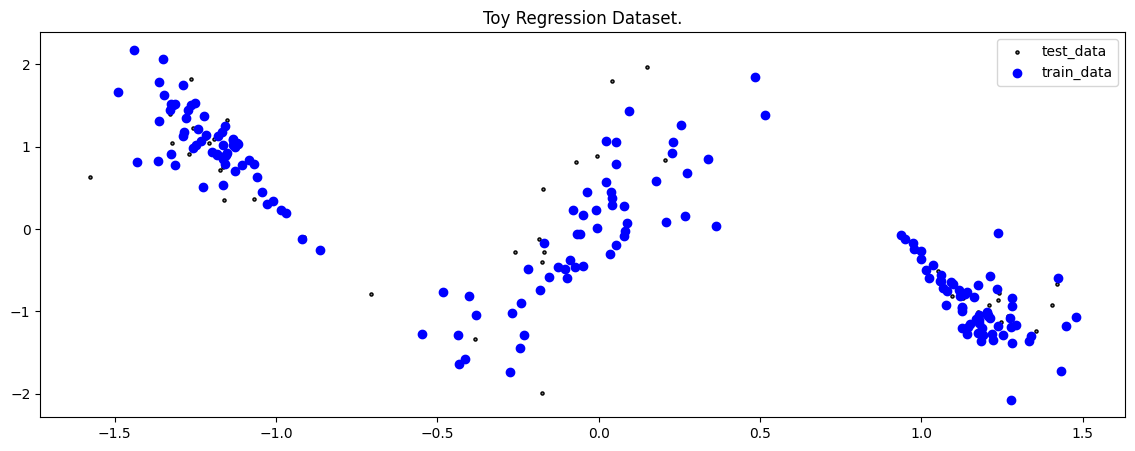

In [6]:
fig = plot_toy_regression_data(X_train, Y_train, X_test, Y_test)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://readthedocs.io/en/stable/api/models.html#MLP).

In [7]:
feature_extractor = MLP(
    n_inputs=1, n_outputs=10, n_hidden=[80], activation_fn=torch.nn.ReLU()
)
feature_extractor

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=80, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=80, out_features=10, bias=True)
  )
)

With an underlying neural network, we can now use our desired UQ-Method as a sort of wrapper. All UQ-Methods are implemented as [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) that allow us to concisely organize the code and remove as much boilerplate code as possible.

In [8]:
dkl_model = DKLRegression(
    feature_extractor=feature_extractor,
    gp_kernel="RBF",
    optimizer=partial(torch.optim.Adam, lr=1e-3),
    n_inducing_points=40,
)

## Trainer

Now that we have a LightningDataModule and a UQ-Method as a LightningModule, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [9]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    accelerator="cpu",
    max_epochs=1000,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
    default_root_dir=my_temp_dir,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training our model is now easy:

In [10]:
trainer.fit(dkl_model, dm)


  | Name              | Type               | Params | Mode 
-----------------------------------------------------------------
0 | feature_extractor | MLP                | 970    | train
1 | train_metrics     | MetricCollection   | 0      | train
2 | val_metrics       | MetricCollection   | 0      | train
3 | test_metrics      | MetricCollection   | 0      | train
4 | gp_layer          | DKLGPLayer         | 2.0 K  | train
5 | scale_to_bounds   | ScaleToBounds      | 0      | train
6 | likelihood        | GaussianLikelihood | 1      | train
7 | elbo_fn           | VariationalELBO    | 2.0 K  | train
-----------------------------------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode
/home/nils/miniconda3/envs/py311uqbox/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'va

## Training Metrics

To get some insights into how the training went, we can use the utility function to plot the training loss and RMSE metric.

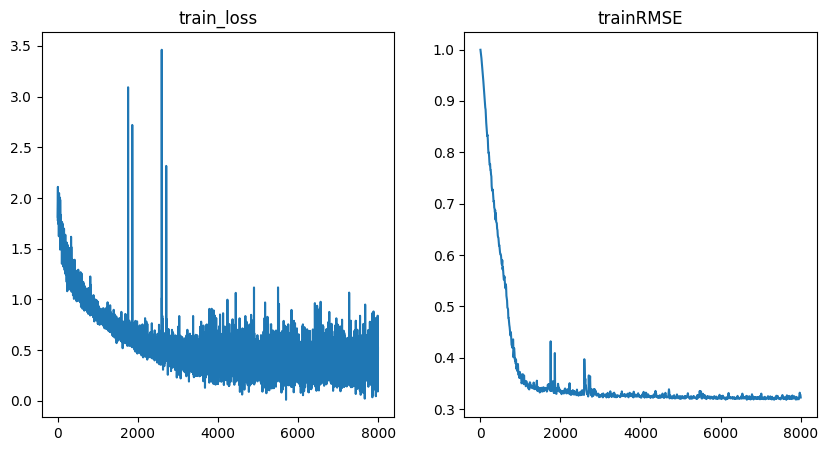

In [11]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainRMSE"]
)

## Evaluate Predictions

The constructed Data Module contains two possible test variable. `X_test` are IID samples from the same noise distribution as the training data, while `X_gtext` ("X ground truth extended") are dense inputs from the underlying "ground truth" function without any noise that also extends the input range to either side, so we can visualize the method's UQ tendencies when extrapolating beyond the training data range. Thus, we will use `X_gtext` for visualization purposes, but use `X_test` to compute uncertainty and calibration metrics because we want to analyse how well the method has learned the noisy data distribution.


INFO:matplotlib.mathtext:Substituting symbol V from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol V from STIXNonUnicode


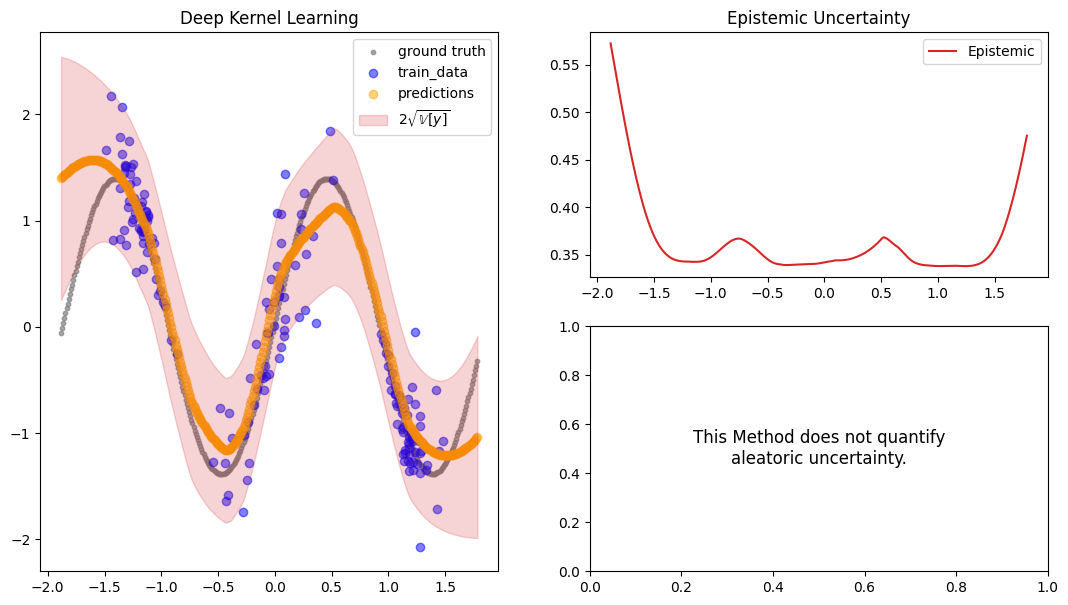

In [12]:
preds = dkl_model.predict_step(X_gtext.to(dkl_model.device))

fig = plot_predictions_regression(
    X_train,
    Y_train,
    X_gtext,
    Y_gtext,
    preds["pred"],
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    title="Deep Kernel Learning",
    show_bands=False,
)

For some additional metrics relevant to UQ, we can use the great [uncertainty-toolbox](https://uncertainty-toolbox.github.io/) that gives us some insight into the calibration of our prediction.

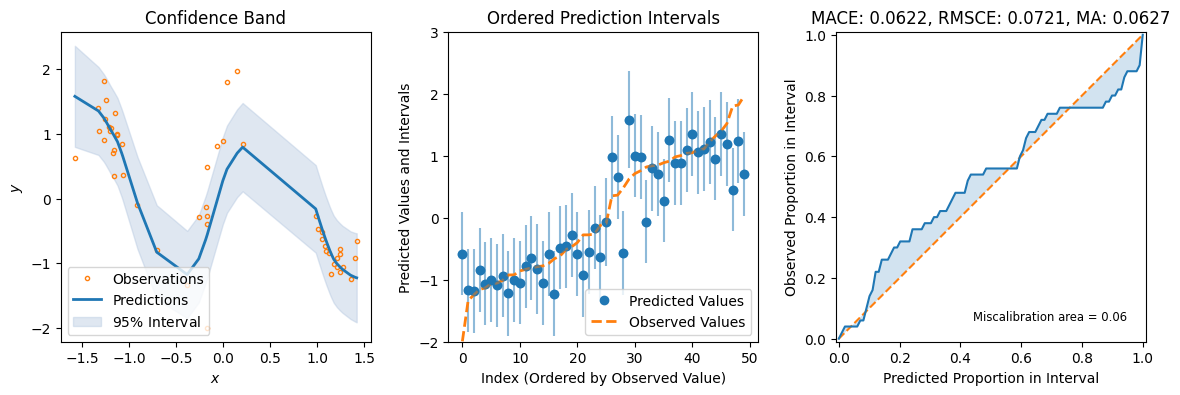

In [ ]:
preds = dkl_model.predict_step(X_test.to(dkl_model.device))
fig = plot_calibration_uq_toolbox(
    preds["pred"].numpy(),
    preds["pred_uct"].numpy(),
    Y_test.cpu().numpy(),
    X_test.cpu().numpy(),
)